# Lecture 16의 데모

### Lecture 16의 데모에 대한 코드

참고자료: 

https://github.com/data-8/materials-sp22/blob/main/lec/lec29.ipynb

https://github.com/data-8/materials-sp22/blob/main/lec/lec30.ipynb


In [1]:
import os
from google.colab import drive

drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/ITEC419-fa22/lec

Mounted at /content/gdrive
/content/gdrive/MyDrive/ITEC419-fa22/lec


In [2]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [3]:
# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about in Data 8.


def resize_window(lim=3.5):
    plots.xlim(-lim, lim)
    plots.ylim(-lim, lim)
    
def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='#1e90ff'):
    y = x*slope + intercept
    plots.plot(x, y, color=color, lw=3)
    
def draw_vertical_line(x_position, color='black'):
    x = make_array(x_position, x_position)
    y = make_array(-4, 4)
    plots.plot(x, y, color=color, lw=3)
    
def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y

def r_scatter(r):
    """Generate a scatter plot with a correlation approximately r"""
    plots.figure(figsize=(5,5))
    x, y = make_correlated_data(r)
    plots.scatter(x, y, color='darkblue', s=20)
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)
    
def r_table(r):
    """
    Generate a table of 1000 data points with a correlation approximately r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

## **Approach to Prediction** (Lecture 7)

In [11]:
# Note: Child heights are the **adult** heights of children in a family
families = Table.read_table('family_heights.csv')
families

family,father,mother,child,children,order,sex
1,78.5,67,73.2,4,1,male
1,78.5,67,69.2,4,2,female
1,78.5,67,69,4,3,female
1,78.5,67,69,4,4,female
2,75.5,66.5,73.5,4,1,male
2,75.5,66.5,72.5,4,2,male
2,75.5,66.5,65.5,4,3,female
2,75.5,66.5,65.5,4,4,female
3,75,64,71,2,1,male
3,75,64,68,2,2,female


In [12]:
# inch-> cm
families.append_column('father', families.apply(lambda x: np.round(x * 2.54, 1), 'father'))
families.append_column('mother', families.apply(lambda x: np.round(x * 2.54, 1), 'mother'))
families.append_column('child', families.apply(lambda x: np.round(x * 2.54, 1), 'child'))
families

family,father,mother,child,children,order,sex
1,199.4,170.2,185.9,4,1,male
1,199.4,170.2,175.8,4,2,female
1,199.4,170.2,175.3,4,3,female
1,199.4,170.2,175.3,4,4,female
2,191.8,168.9,186.7,4,1,male
2,191.8,168.9,184.2,4,2,male
2,191.8,168.9,166.4,4,3,female
2,191.8,168.9,166.4,4,4,female
3,190.5,162.6,180.3,2,1,male
3,190.5,162.6,172.7,2,2,female


In [15]:
parent_avgs = (families.column('father') + families.column('mother'))/2

In [16]:
heights = Table().with_columns(
    'Parent Average', parent_avgs,
    'Child', families.column('child'),
)
heights #new table

Parent Average,Child
184.8,185.9
184.8,175.8
184.8,175.3
184.8,175.3
180.35,186.7
180.35,184.2
180.35,166.4
180.35,166.4
176.55,180.3
176.55,172.7


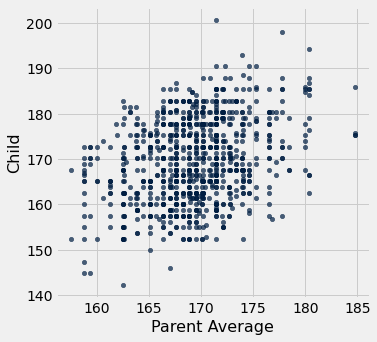

In [17]:
heights.scatter('Parent Average', 'Child')

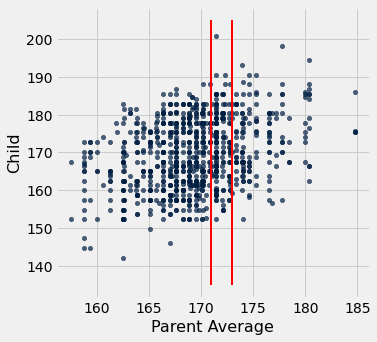

In [18]:
heights.scatter('Parent Average', 'Child')
plots.plot([171.0, 171.0], [135.0, 205.0], color='red', lw=2)
plots.plot([173.0, 173.0], [135.0, 205.0], color='red', lw=2);

In [19]:
nearby = heights.where('Parent Average', are.between(171.0, 173.0))# 뽑아내기
nearby_mean = np.average(nearby.column('Child'))# 뽑아낸 것의 평균
nearby_mean

171.54682080924857

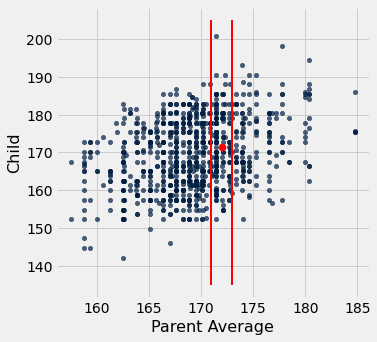

In [20]:
heights.scatter('Parent Average', 'Child')
plots.plot([171.0, 171.0], [135.0, 205.0], color='red', lw=2)
plots.plot([173.0, 173.0], [135.0, 205.0], color='red', lw=2)
plots.scatter(172.0, nearby_mean, color='red', s=50);

In [21]:
def predict_child(h):
    """Predict the height of a child whose parents have a parent average height of p_avg.
    
    The prediction is the average height of the children whose parent average height is
    in the range p_avg plus or minus 1.0.
    """
    nearby = heights.where('Parent Average', are.between(h - 1.0, h + 1.0))
    return np.average(nearby.column('Child'))

In [22]:
heights_with_predictions = heights.with_columns(
    'Prediction', heights.apply(predict_child, 'Parent Average'))

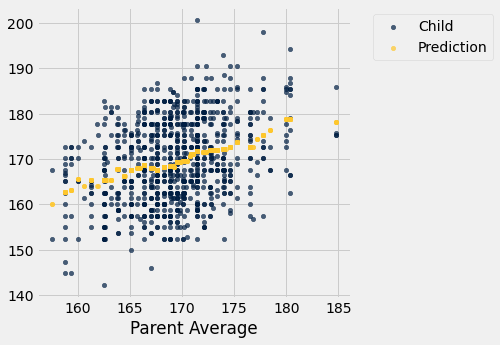

In [23]:
heights_with_predictions.scatter('Parent Average')

## **Association**

In [24]:
hybrid = Table.read_table('hybrid.csv')
hybrid

vehicle,year,msrp,acceleration,mpg,class
Prius (1st Gen),1997,24509.7,7.46,41.26,Compact
Tino,2000,35355,8.2,54.1,Compact
Prius (2nd Gen),2000,26832.2,7.97,45.23,Compact
Insight,2000,18936.4,9.52,53,Two Seater
Civic (1st Gen),2001,25833.4,7.04,47.04,Compact
Insight,2001,19036.7,9.52,53,Two Seater
Insight,2002,19137,9.71,53,Two Seater
Alphard,2003,38084.8,8.33,40.46,Minivan
Insight,2003,19137,9.52,53,Two Seater
Civic,2003,14071.9,8.62,41,Compact


In [25]:
hybrid.sort('msrp', descending=True) # 비싼 가격부터 해서 밑으로 내려감. 

vehicle,year,msrp,acceleration,mpg,class
Lexus LS600h/hL,2007,118544,17.54,21,Midsize
ActiveHybrid 7,2010,104300,20.41,22.11,Large
ActiveHybrid 7i,2011,102606,18.18,20,Midsize
ActiveHybrid X6,2009,97237.9,17.96,18.82,SUV
S400 Long,2009,96208.9,13.89,26.34,Large
Panamera S,2013,96150,18.52,25,Large
Panamera S,2012,95283.9,17.54,25,Large
S400,2013,92350,13.89,21,Large
S400,2010,88212.8,12.99,21,Large
ActiveHybrid 7L,2013,84300,18.18,25,Large


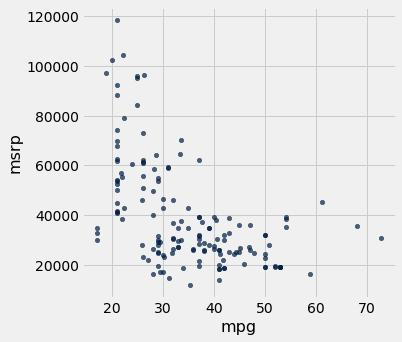

In [26]:
hybrid.scatter('mpg', 'msrp')

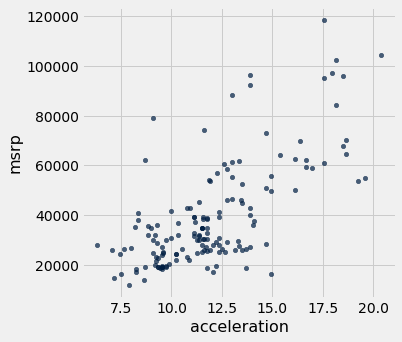

In [27]:
hybrid.scatter('acceleration', 'msrp')

In [28]:
suv = hybrid.where('class', 'SUV') # 자동차 class에 따라 많이 달라지기 때문에 suv만 뽑아서 보기
suv.num_rows

39

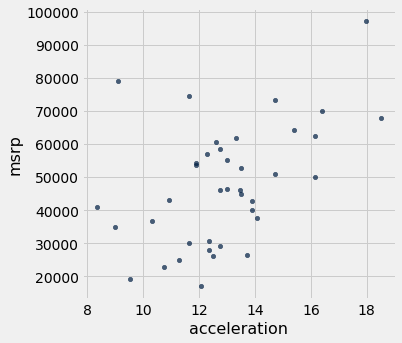

In [29]:
suv.scatter('acceleration', 'msrp')

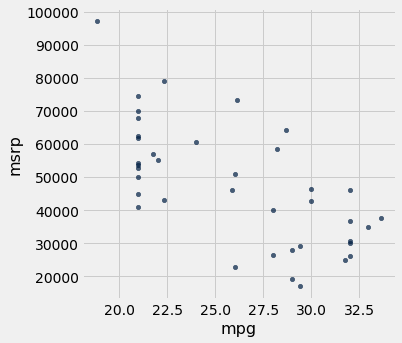

In [30]:
suv.scatter('mpg', 'msrp')

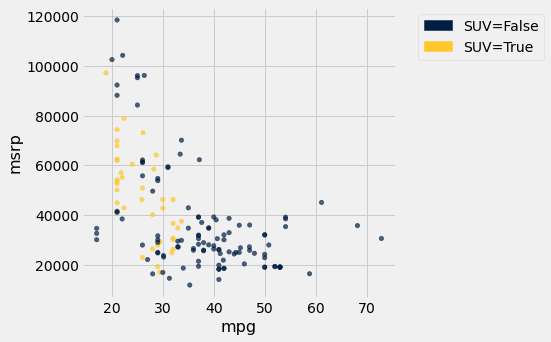

In [31]:
hybrid.with_column('SUV', hybrid.column('class') == 'SUV').scatter('mpg', 'msrp', group='SUV')

In [33]:
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x)) / np.std(x) # 이게 표준 편차

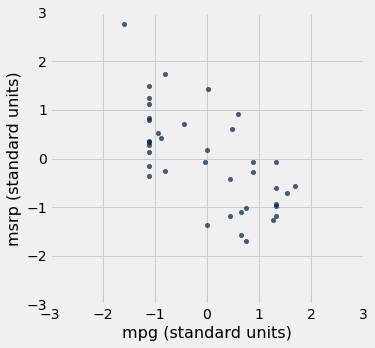

In [34]:
Table().with_columns(
    'mpg (standard units)',  standard_units(suv.column('mpg')), 
    'msrp (standard units)', standard_units(suv.column('msrp'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

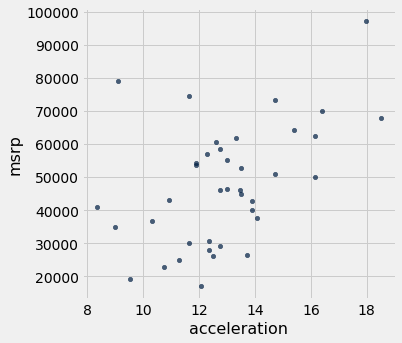

In [35]:
suv.scatter('acceleration', 'msrp')

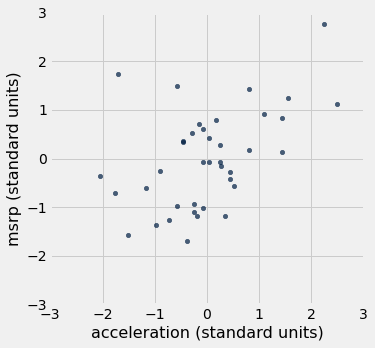

In [36]:
Table().with_columns(
    'acceleration (standard units)', standard_units(suv.column('acceleration')), 
    'msrp (standard units)',         standard_units(suv.column('msrp'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

## **Correlation**

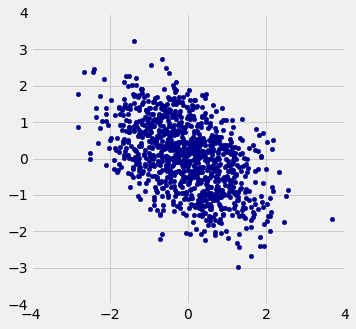

In [38]:
r_scatter(-0.5)
 # r_scatter 함수 : r을 주고, x,y 데이터를 인위적으로 만든 후 scatter


In [39]:
x = np.arange(1, 7, 1)
y = make_array(2, 3, 1, 5, 2, 7)
t = Table().with_columns(
        'x', x,
        'y', y
    )
t

x,y
1,2
2,3
3,1
4,5
5,2
6,7


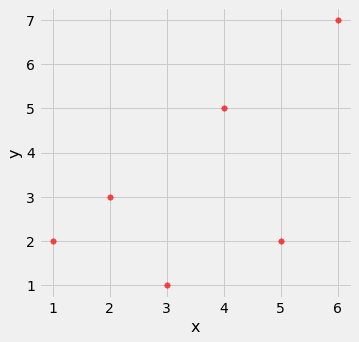

In [40]:
t.scatter('x', 'y', s=30, color='red')

In [41]:
t = t.with_columns(
        'x (standard units)', standard_units(x),
        'y (standard units)', standard_units(y)
    )
t

x,y,x (standard units),y (standard units)
1,2,-1.46385,-0.648886
2,3,-0.87831,-0.162221
3,1,-0.29277,-1.13555
4,5,0.29277,0.811107
5,2,0.87831,-0.648886
6,7,1.46385,1.78444


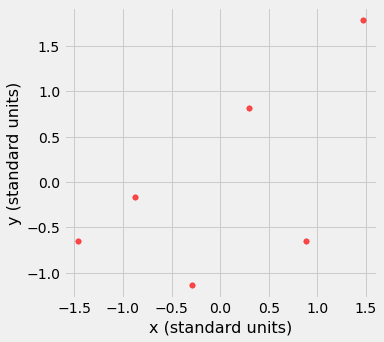

In [42]:
t.scatter(2, 3, s=30, color='red')

In [43]:
t = t.with_columns(
    'product of standard units', t.column(2) * t.column(3))
t # 각각을 곱해서 나온 것을 평균 낸 것

x,y,x (standard units),y (standard units),product of standard units
1,2,-1.46385,-0.648886,0.949871
2,3,-0.87831,-0.162221,0.142481
3,1,-0.29277,-1.13555,0.332455
4,5,0.29277,0.811107,0.237468
5,2,0.87831,-0.648886,-0.569923
6,7,1.46385,1.78444,2.61215


In [45]:
# r is the average of the products of the standard units

r = np.average(t.column(2) * t.column(3))
r # 두개의 값들의 column들의 항들을 곱해서 평균 낸 것

0.61741639718977093

In [48]:
def correlation(t, x, y): # t에 x,y(column lable)를 주면  구 lable의 correlation을 구할 수 있음. ㄴ
    """t is a table; x and y are column labels"""
    x_in_standard_units = standard_units(t.column(x))
    y_in_standard_units = standard_units(t.column(y))
    return np.average(x_in_standard_units * y_in_standard_units)# 둘다 각각 곱해서 np average로 평균 낸 것

In [47]:
correlation(t, 'x', 'y')

0.61741639718977093

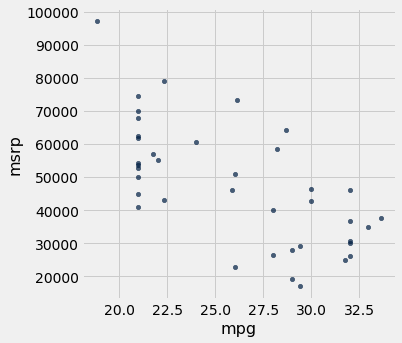

In [49]:
suv.scatter('mpg', 'msrp')

In [50]:
correlation(suv, 'mpg', 'msrp')

-0.6667143635709919

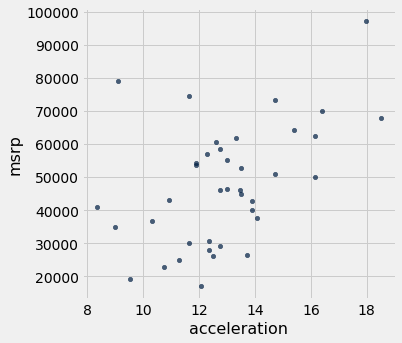

In [51]:
suv.scatter('acceleration', 'msrp')

In [52]:
correlation(suv, 'acceleration', 'msrp')

0.48699799279959155

### **Switching Axes**

In [53]:
correlation(t, 'x', 'y')

0.61741639718977093

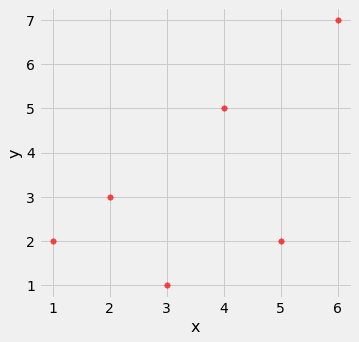

In [54]:
t.scatter('x', 'y', s=30, color='red')

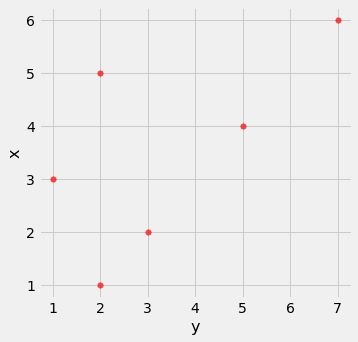

In [55]:
t.scatter('y', 'x', s=30, color='red')

In [60]:
correlation(t, 'y', 'x') # 그래프는 다른데 correlation의 값을 같다.

0.61741639718977093

### **Nonlinearity**

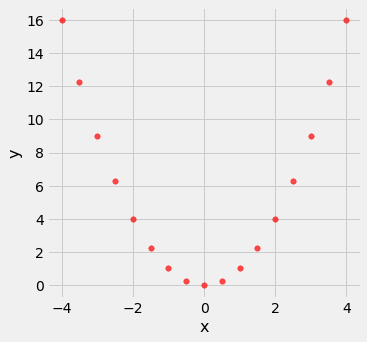

In [61]:
new_x = np.arange(-4, 4.1, 0.5) # 새로 테이블을 하나 만듬. (4까지 하려고 4.1 -> 0.5씩 증가)
nonlinear = Table().with_columns(
        'x', new_x,
        'y', new_x**2
    )
nonlinear.scatter('x', 'y', s=30, color='r')
# 이차함수 관계식 

In [58]:
correlation(nonlinear, 'x', 'y') 
# 여기는 곱하면 +고 왼쪽은 - 니까 더하면 0이 되겠지 라고 하심.  (관계는 있는데 notlinear함.)

0.0

### **Outliers**

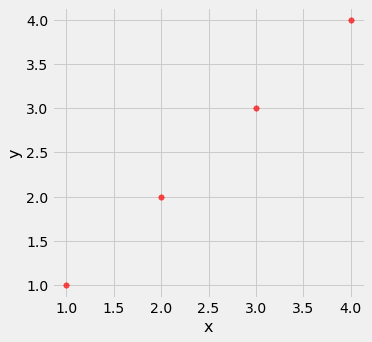

In [62]:
line = Table().with_columns(
        'x', make_array(1, 2, 3, 4),
        'y', make_array(1, 2, 3, 4)
    )
line.scatter('x', 'y', s=30, color='r')
# perfect 하게 

In [63]:
correlation(line, 'x', 'y')
# 완벽하게 1.0

1.0

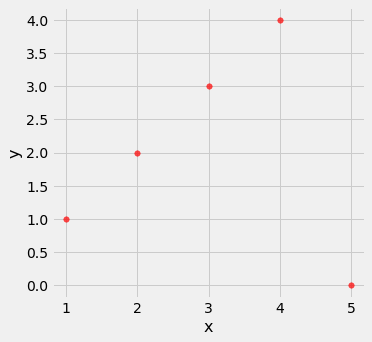

In [64]:
outlier = Table().with_columns(
        'x', make_array(1, 2, 3, 4, 5),
        'y', make_array(1, 2, 3, 4, 0)
    )
outlier.scatter('x', 'y', s=30, color='r')

In [65]:
correlation(outlier, 'x', 'y')
#  엉뚱한 데이터 하나만 딱 들어가도 0.0 나와벌임...;;

0.0

### **Ecological Correlations**

In [67]:
sat2014 = Table.read_table('sat2014.csv').sort('State') # 미국의 수능 시험
sat2014

State,Participation Rate,Critical Reading,Math,Writing,Combined
Alabama,6.7,547,538,532,1617
Alaska,54.2,507,503,475,1485
Arizona,36.4,522,525,500,1547
Arkansas,4.2,573,571,554,1698
California,60.3,498,510,496,1504
Colorado,14.3,582,586,567,1735
Connecticut,88.4,507,510,508,1525
Delaware,100,456,459,444,1359
District of Columbia,100,440,438,431,1309
Florida,72.2,491,485,472,1448


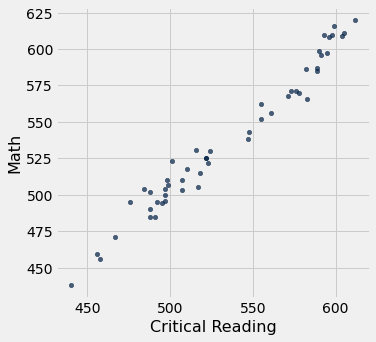

In [68]:
sat2014.scatter('Critical Reading', 'Math')

In [69]:
correlation(sat2014, 'Critical Reading', 'Math')

0.98475584110674341

In [70]:
def rate_code(x):
    if x <= 25:
        return 'low'
    elif x <= 75:
        return 'medium'
    else:
        return 'high'

In [71]:
rate_codes = sat2014.apply(rate_code, 'Participation Rate')

In [72]:
sat2014 = sat2014.with_columns('Rate Code', rate_codes) # 마지막에 rate code열이 하나 더 늘었음
sat2014

State,Participation Rate,Critical Reading,Math,Writing,Combined,Rate Code
Alabama,6.7,547,538,532,1617,low
Alaska,54.2,507,503,475,1485,medium
Arizona,36.4,522,525,500,1547,medium
Arkansas,4.2,573,571,554,1698,low
California,60.3,498,510,496,1504,medium
Colorado,14.3,582,586,567,1735,low
Connecticut,88.4,507,510,508,1525,high
Delaware,100,456,459,444,1359,high
District of Columbia,100,440,438,431,1309,high
Florida,72.2,491,485,472,1448,medium


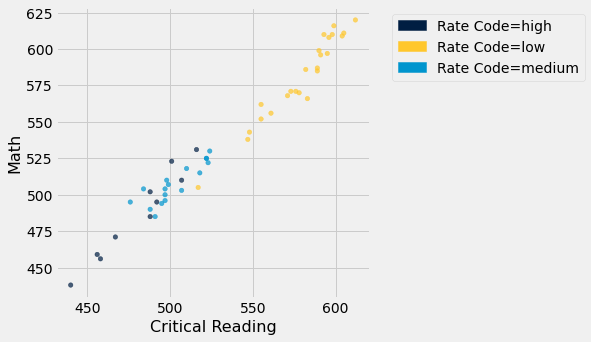

In [73]:
sat2014.scatter('Critical Reading', 'Math', group='Rate Code') # rate가 낮은데는 점수가 높음 (안정학한 무지성 필기)

In [74]:
sat2014.where('Rate Code', 'low').show() # low에 해당되는 것만 뽑아서 

State,Participation Rate,Critical Reading,Math,Writing,Combined,Rate Code
Alabama,6.7,547,538,532,1617,low
Arkansas,4.2,573,571,554,1698,low
Colorado,14.3,582,586,567,1735,low
Illinois,4.6,599,616,587,1802,low
Iowa,3.1,605,611,578,1794,low
Kansas,5.3,591,596,566,1753,low
Kentucky,4.6,589,585,572,1746,low
Louisiana,4.6,561,556,550,1667,low
Michigan,3.8,593,610,581,1784,low
Minnesota,5.9,598,610,578,1786,low


## **Prediction Lines**

### **r = 0.99**

In [75]:
example = r_table(0.99)
example.show(3)

x,y
0.0912047,-0.0680119
1.09128,1.04391
-1.94697,-1.88316


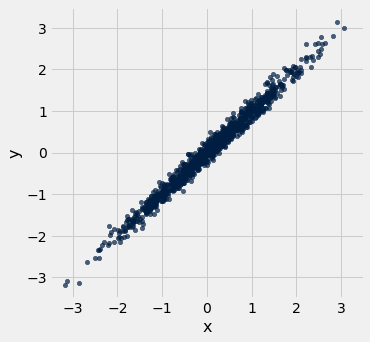

In [76]:
example.scatter('x', 'y')
resize_window()

In [78]:
def nn_prediction_example(x_val):
    """ Predicts y-value for x based on the example table """
    neighbors = example.where('x', are.between(x_val - .25, x_val + .25))
    return np.mean(neighbors.column('y'))   

In [81]:
nn_prediction_example(-2.25)

-2.1476337989800522

In [80]:
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))

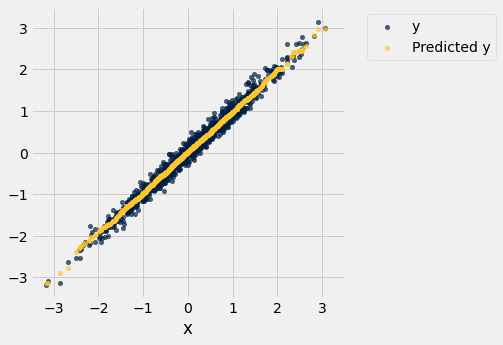

In [82]:
example.scatter('x')
resize_window()

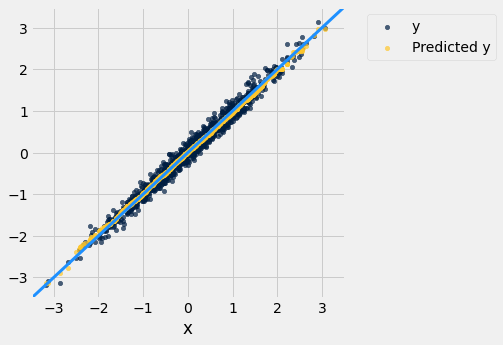

In [83]:
example.scatter('x')
draw_line(slope=1)
resize_window()

### **r = 0**

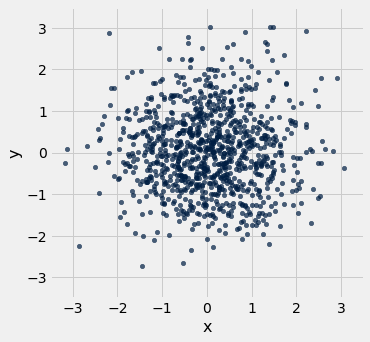

In [84]:
example = r_table(0)
example.scatter('x', 'y')
resize_window()

In [85]:
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))

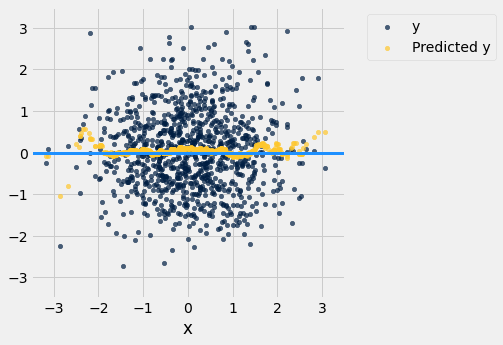

In [86]:
example.scatter('x')
draw_line(slope = 0)
resize_window()

### **r = 0.5**

In [ ]:
example = r_table(0.5)
example.scatter('x', 'y')
resize_window()

In [ ]:
example = r_table(0.5)
example.scatter('x', 'y')
resize_window()
draw_vertical_line(1.5)
draw_line(slope=1, intercept=0, color='red')

In [ ]:
example = example.with_column('Predicted y', example.apply(nn_prediction_example, 'x'))
example.scatter('x')
draw_line(slope=1, color='red')
draw_vertical_line(1.5)
resize_window()

In [ ]:
example.scatter('x')
draw_line(slope=1, intercept=0, color='red')
draw_line(slope=0.5, intercept=0)
resize_window()

###  **r = 0.7**

In [ ]:
example = r_table(0.7)
example = example.with_column('Predicted y', example.apply(nn_prediction_example, 'x'))
example.scatter('x')
draw_line(slope=1, intercept=0, color='red')
draw_line(slope=0.7, intercept=0, color='dodgerblue')
resize_window()